In [1]:
!pip install torch torch-geometric scikit-learn pandas networkx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 5.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [2]:
pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.


## Load the Data and Preprocess

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your CSV
student_data = pd.read_csv('synthetic_student_data.csv')

# Create the new features
student_data_processed = student_data.copy()

# Wellbeing Score
student_data_processed['Wellbeing_Score'] = (
    student_data_processed['pwi_wellbeing'] + student_data_processed['k6_overall']
) / 2

# Friendliness Score
student_data_processed['Friendliness_Score'] = student_data_processed['School_support_engage']

# Bullying Score
student_data_processed['Bullying_Score'] = student_data_processed['criticises']

# Normalize
scaler = MinMaxScaler()
student_data_processed[['Academic_Performance', 'Wellbeing_Score', 'Friendliness_Score']] = scaler.fit_transform(
    student_data_processed[['Academic_Performance', 'Wellbeing_Score', 'Friendliness_Score']]
)

# Composite Score
student_data_processed['Composite_Score'] = (
    0.7 * student_data_processed['Academic_Performance'] +
    0.2 * student_data_processed['Wellbeing_Score'] +
    0.1 * student_data_processed['Friendliness_Score']
)

# Identify potential bullies
student_data_processed['Potential_Bully'] = student_data_processed['Bullying_Score'] > 5

# Check result
student_data_processed[['StudentID', 'Academic_Performance', 'Wellbeing_Score', 
                         'Friendliness_Score', 'Bullying_Score', 'Composite_Score', 
                         'Potential_Bully']].head()


,StudentID,Academic_Performance,Wellbeing_Score,Friendliness_Score,Bullying_Score,Composite_Score,Potential_Bully
0,S0001,0.6750,0.541667,0.291667,6,0.610000,True
1,S0002,0.6500,0.583333,0.500000,5,0.621667,False
2,S0003,0.8875,0.750000,0.458333,4,0.817083,False
3,S0004,0.4625,0.916667,0.583333,7,0.565417,True
4,S0005,0.5875,0.291667,0.500000,2,0.519583,False


## Build the Edge List

In [4]:
import torch
from torch_geometric.data import Data
import networkx as nx

# Build a dictionary: StudentID -> Row Index
student_id_to_idx = {sid: idx for idx, sid in enumerate(student_data_processed['StudentID'])}

# Build the edge list
edge_index_list = []

for idx, row in student_data_processed.iterrows():
    if pd.notna(row['Friends']):  # if the student has friends listed
        friends = row['Friends'].split(', ')
        for friend_id in friends:
            if friend_id in student_id_to_idx:
                edge_index_list.append([idx, student_id_to_idx[friend_id]])

# Convert to PyTorch tensor
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

print(f"Edge Index Shape: {edge_index.shape}")
print(f"Example Edges: \n{edge_index[:, :5]}")


Edge Index Shape: torch.Size([2, 3474])
Example Edges: 
tensor([[  0,   0,   0,   0,   0],
        [188, 388, 977, 362,  86]])


## Build Node Features



In [5]:
# Select the features to be used
node_features = student_data_processed[[
    'Academic_Performance', 'Wellbeing_Score', 
    'Friendliness_Score', 'Bullying_Score', 
    'Composite_Score'
]].values

# Convert to PyTorch tensor
x = torch.tensor(node_features, dtype=torch.float)

print(f"Node Feature Shape: {x.shape}")


Node Feature Shape: torch.Size([1000, 5])


## Build GNN Data Object



In [6]:
# Create PyG Data object
data = Data(x=x, edge_index=edge_index)

print(data)


Data(x=[1000, 5], edge_index=[2, 3474])


## Import Necessary GNN Layers

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


## Define a Simple 2-Layer GCN

In [8]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


## Initialize Model

In [10]:
# Initialize model
model = GCN(input_dim=5, hidden_dim=16, output_dim=2)

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function (not training labels yet, so unsupervised)
loss_fn = nn.MSELoss()  # dummy, we will mainly use embeddings


In [11]:
# Set model to evaluation mode
model.eval()

# Forward pass
with torch.no_grad():
    out = model(data)

print("Output Embeddings Shape:", out.shape)
print("Example Embedding for Student 0:", out[0])


Output Embeddings Shape: torch.Size([1000, 2])
Example Embedding for Student 0: tensor([1.6091, 1.2046])


## Visualize the GNN Outputs in 2D


## Basic Scatter Plot of Student Embeddings

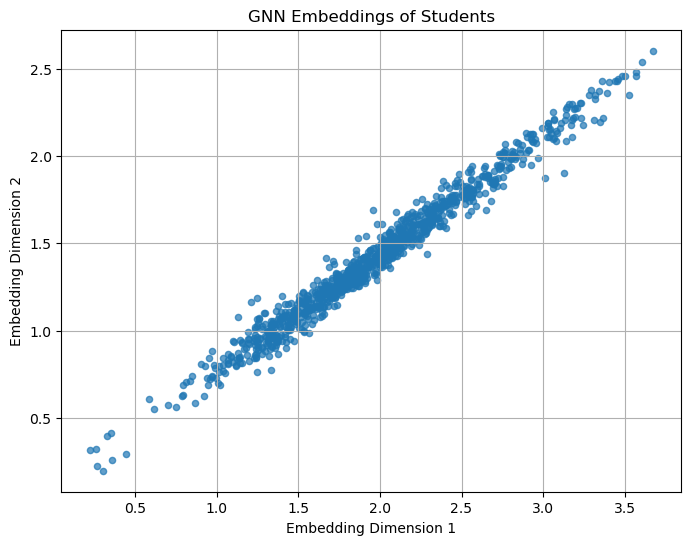

In [12]:
import matplotlib.pyplot as plt

# Plot the embeddings
plt.figure(figsize=(8,6))
plt.scatter(out[:, 0].cpu(), out[:, 1].cpu(), s=20, alpha=0.7)

plt.title("GNN Embeddings of Students")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()


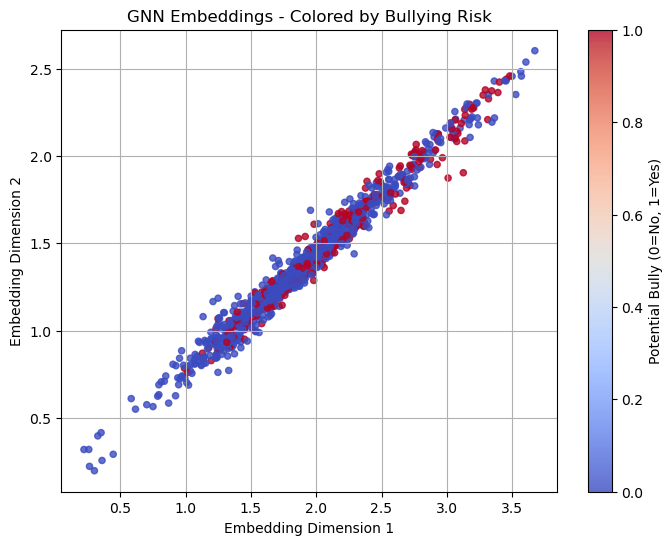

In [13]:
# Color by bully status
bully_labels = student_data_processed['Potential_Bully'].astype(int)

plt.figure(figsize=(8,6))
scatter = plt.scatter(out[:, 0].cpu(), out[:, 1].cpu(), c=bully_labels, cmap='coolwarm', s=20, alpha=0.8)

plt.title("GNN Embeddings - Colored by Bullying Risk")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.colorbar(scatter, label="Potential Bully (0=No, 1=Yes)")
plt.grid(True)
plt.show()


In [14]:
from sklearn.cluster import KMeans

# How many classrooms you want
NUM_CLASSES = 10

# Apply KMeans clustering on GNN outputs
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=42)
student_clusters = kmeans.fit_predict(out.cpu().numpy())

# Save classroom assignments
student_data_processed['Assigned_Classroom'] = student_clusters

# View result
student_data_processed[['StudentID', 'Assigned_Classroom']].head()


,StudentID,Assigned_Classroom
0,S0001,1
1,S0002,7
2,S0003,2
3,S0004,7
4,S0005,6


In [15]:
# Average Composite Score per classroom
classroom_summary = student_data_processed.groupby('Assigned_Classroom').agg({
    'Academic_Performance': 'mean',
    'Wellbeing_Score': 'mean',
    'Friendliness_Score': 'mean',
    'Potential_Bully': 'sum',  # count how many potential bullies
    'StudentID': 'count'  # total students
}).rename(columns={'StudentID': 'Class_Size'})

# Display
classroom_summary


,Academic_Performance,Wellbeing_Score,Friendliness_Score,Potential_Bully,Class_Size
Assigned_Classroom,,,,,
0,0.629963,0.546262,0.495711,44,136
1,0.586516,0.544619,0.486877,34,127
2,0.649821,0.515476,0.510714,32,70
3,0.606609,0.532567,0.483477,53,174
4,0.567378,0.533537,0.504065,2,41
5,0.617828,0.534836,0.507514,23,122
6,0.631658,0.532156,0.472826,46,184
7,0.629487,0.547009,0.510684,15,39
8,0.619571,0.529040,0.476010,32,99


In [ ]:

# --- Full Constraint Evaluation After GNN Clustering ---

# Constraint Thresholds
max_allowed_difference = 15  # Academic score max diff
max_allowed_wellbeing_diff = 2  # Wellbeing score max diff
max_bullies_per_class = 2  # Max allowed bullies per class

# 1. Check Academic Score Balance
academic_diff = classroom_summary['Academic_Performance'].max() - classroom_summary['Academic_Performance'].min()
print(f"Academic Score Difference: {academic_diff:.2f} (Limit: {max_allowed_difference})")
if academic_diff > max_allowed_difference:
    print("❌ Academic score balance constraint violated.")
else:
    print("✅ Academic score balance constraint satisfied.")

# 2. Check Wellbeing Balance
wellbeing_diff = classroom_summary['Wellbeing_Score'].max() - classroom_summary['Wellbeing_Score'].min()
print(f"Wellbeing Score Difference: {wellbeing_diff:.2f} (Limit: {max_allowed_wellbeing_diff})")
if wellbeing_diff > max_allowed_wellbeing_diff:
    print("❌ Wellbeing balance constraint violated.")
else:
    print("✅ Wellbeing balance constraint satisfied.")

# 3. Check Bullying Spread Constraint
violating_classes = classroom_summary[classroom_summary['Potential_Bully'] > max_bullies_per_class]
if not violating_classes.empty:
    print(f"❌ {len(violating_classes)} classroom(s) exceed the bullying constraint.")
    print(violating_classes[['Potential_Bully']])
else:
    print("✅ Bullying spread constraint satisfied.")

# 4. Check Class Size Balance
class_sizes = classroom_summary['Class_Size']
size_diff = class_sizes.max() - class_sizes.min()
print(f"Class Size Range: {class_sizes.min()} - {class_sizes.max()} (Diff = {size_diff})")
if size_diff > 10:
    print("⚠️ Warning: Significant difference in class sizes.")
else:
    print("✅ Class sizes are reasonably balanced.")


In [16]:
from sklearn.cluster import KMeans

# Set number of classrooms
NUM_CLASSES = 10

# Apply KMeans clustering on GNN output embeddings
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=42)
student_clusters = kmeans.fit_predict(out.cpu().numpy())

# Add classroom assignment to the dataframe
student_data_processed['Assigned_Classroom'] = student_clusters

# View some samples
student_data_processed[['StudentID', 'Assigned_Classroom']].head()


,StudentID,Assigned_Classroom
0,S0001,1
1,S0002,7
2,S0003,2
3,S0004,7
4,S0005,6


In [17]:
# Summarize classroom stats
classroom_summary = student_data_processed.groupby('Assigned_Classroom').agg({
    'Academic_Performance': 'mean',
    'Wellbeing_Score': 'mean',
    'Friendliness_Score': 'mean',
    'Potential_Bully': 'sum',  # how many bullies in each class
    'StudentID': 'count'  # class size
}).rename(columns={'StudentID': 'Class_Size'})

# Show summary
classroom_summary


,Academic_Performance,Wellbeing_Score,Friendliness_Score,Potential_Bully,Class_Size
Assigned_Classroom,,,,,
0,0.629963,0.546262,0.495711,44,136
1,0.586516,0.544619,0.486877,34,127
2,0.649821,0.515476,0.510714,32,70
3,0.606609,0.532567,0.483477,53,174
4,0.567378,0.533537,0.504065,2,41
5,0.617828,0.534836,0.507514,23,122
6,0.631658,0.532156,0.472826,46,184
7,0.629487,0.547009,0.510684,15,39
8,0.619571,0.529040,0.476010,32,99


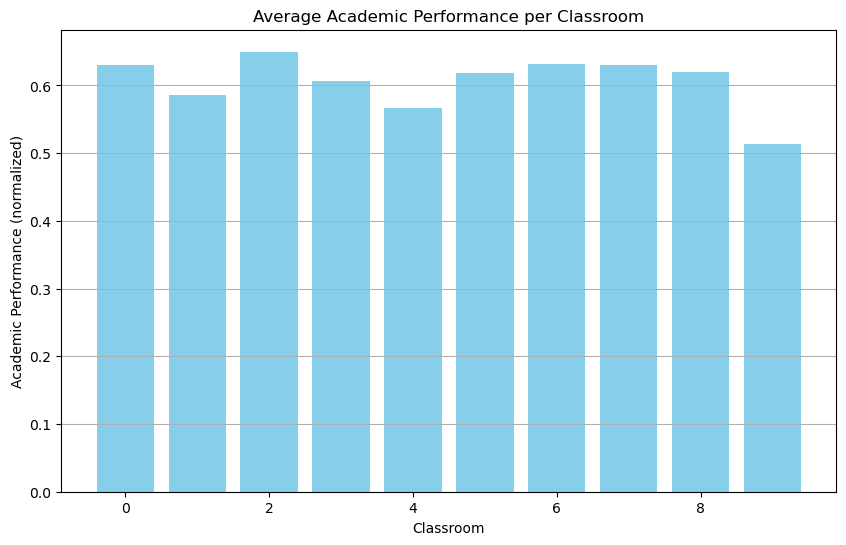

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(classroom_summary.index, classroom_summary['Academic_Performance'], color='skyblue')
plt.title('Average Academic Performance per Classroom')
plt.xlabel('Classroom')
plt.ylabel('Academic Performance (normalized)')
plt.grid(axis='y')
plt.show()


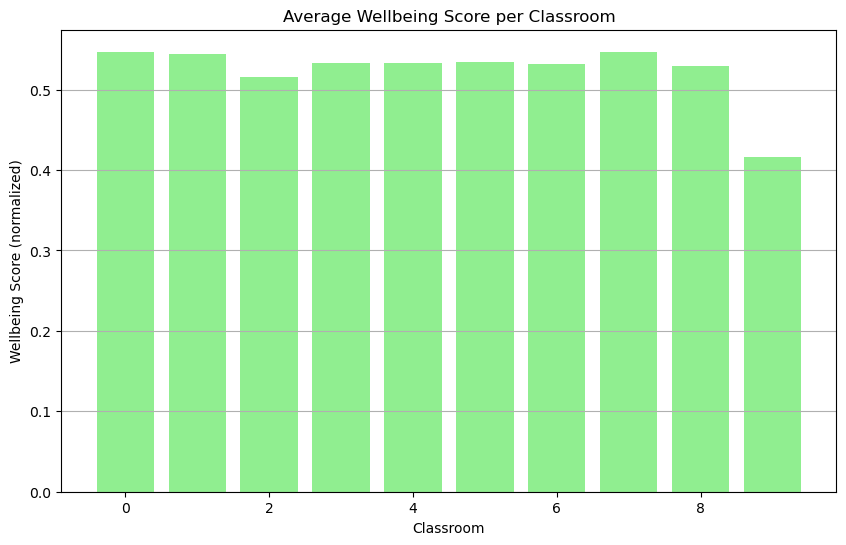

In [19]:
plt.figure(figsize=(10,6))
plt.bar(classroom_summary.index, classroom_summary['Wellbeing_Score'], color='lightgreen')
plt.title('Average Wellbeing Score per Classroom')
plt.xlabel('Classroom')
plt.ylabel('Wellbeing Score (normalized)')
plt.grid(axis='y')
plt.show()


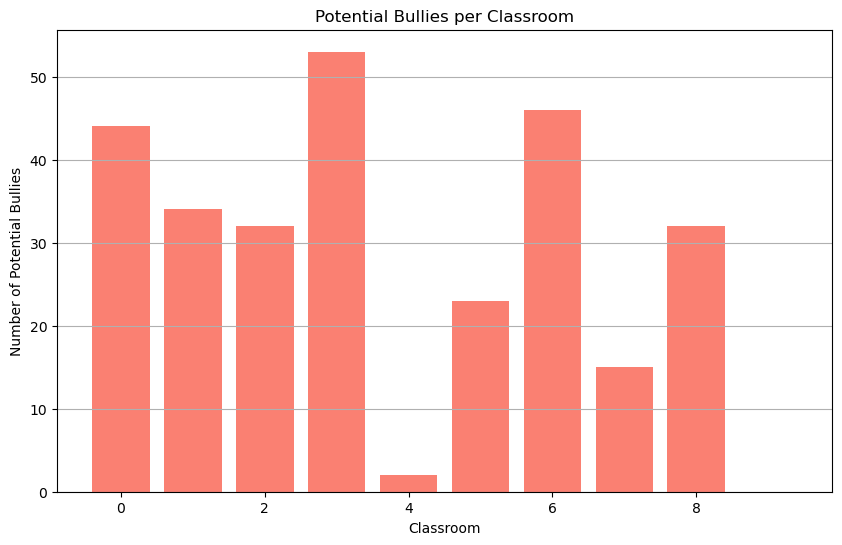

In [20]:
plt.figure(figsize=(10,6))
plt.bar(classroom_summary.index, classroom_summary['Potential_Bully'], color='salmon')
plt.title('Potential Bullies per Classroom')
plt.xlabel('Classroom')
plt.ylabel('Number of Potential Bullies')
plt.grid(axis='y')
plt.show()


In [21]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score based on GNN embeddings and assigned classroom
sil_score = silhouette_score(out.cpu().numpy(), student_data_processed['Assigned_Classroom'])

print(f"Silhouette Score for GNN + KMeans Grouping: {sil_score:.4f}")


Silhouette Score for GNN + KMeans Grouping: 0.4671


In [22]:
# Calculate std deviation across classrooms
classroom_variance = classroom_summary[['Academic_Performance', 'Wellbeing_Score', 'Friendliness_Score']].std()

print("Standard Deviation Across Classrooms:")
print(classroom_variance)


Standard Deviation Across Classrooms:
Academic_Performance    0.039927
Wellbeing_Score         0.038602
Friendliness_Score      0.032976
dtype: float64
